## Table of contents:

1. [Introduction](#P1)
2. [Load packages and data tables](#P2)
    1. [Merge data frames](#P21)
3. [Exploratory data analysis](#P3)
    1. [Create features](#P31)
    2. [Evaluate the randomness of the test group assignment](#P32)
4. [Compare conversion and revenue by control and test group](#P4)
    1. [Differences in conversion](#P41)
    2. [Differences in revenue](#P42)
5. [Insights into consumer behavior](#P5)
6. [How long should the experiment been run for?](#P6)
7. [Conclusions](#P7)




## Introduction<a name="P1"></a>


The goal to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.

Company XYZ sells a software for 39 dollars, but they have run an experiment to evaluate if how increasing the price to 59 dollars changes customer purchases.

The VP of Product has asked:

1. Should the company sell the software for 39 or 59?

2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

3. The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Explain why.

__Assumptions I made are in bold.__ _Questions I have are in italics_

## Load packages and data tables<a name="P2"></a>


In [32]:
import pandas as pd
from scipy import stats
from scipy.stats import fisher_exact
from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu
import numpy as np
import re
import datetime
import pathlib
import urllib.request
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import random
import numpy
from matplotlib import pyplot
import seaborn as sns
from statsmodels.stats import power
from datetime import *
from geopandas import GeoSeries



In [7]:
user_table = pd.read_csv('/Users/rasmussenrogers/Downloads/user_table.txt')
print("shape of user table", user_table.shape)


shape of user table (275616, 5)


In [8]:
test_results = pd.read_csv('/Users/rasmussenrogers/Downloads/test_results.txt')
print("shape of test table", test_results.shape)


shape of test table (316800, 9)


### Merge tables <a name="P21"></a>

In [9]:
merge_data = pd.merge(test_results, user_table, on='user_id', how='outer')
print("shape of merged table", merge_data.shape)

shape of merged table (316800, 13)


## Exploratory data analysis<a name="P3"></a>


In [10]:
merge_data.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,35.07,-78.90
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02


In [11]:
merge_data.describe(include='all')

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
count,316800.000000,316800.000000,316466,316488,316800,296461,316800.000000,3.168000e+05,316800.000000,275616,275616,275616.000000,275616.000000
unique,NaN,NaN,141147,12,2,8,NaN,NaN,NaN,923,1,NaN,NaN
top,NaN,NaN,2015-04-12 11:51:16,direct_traffic,mobile,windows,NaN,NaN,NaN,New York,USA,NaN,NaN
freq,NaN,NaN,12,60307,186471,100878,NaN,NaN,NaN,25748,275616,NaN,NaN
mean,158399.500000,499281.341840,NaN,NaN,NaN,NaN,0.360079,6.457590e+06,0.018333,NaN,NaN,37.111680,-93.981772
std,91452.426977,288591.154044,NaN,NaN,NaN,NaN,0.480024,6.797307e+07,0.134154,NaN,NaN,5.209627,18.086486
min,0.000000,3.000000,NaN,NaN,NaN,NaN,0.000000,3.900000e+01,0.000000,NaN,NaN,19.700000,-157.800000
25%,79199.750000,249525.750000,NaN,NaN,NaN,NaN,0.000000,3.900000e+01,0.000000,NaN,NaN,33.660000,-112.200000
50%,158399.500000,499021.500000,NaN,NaN,NaN,NaN,0.000000,3.900000e+01,0.000000,NaN,NaN,37.740000,-88.930000
75%,237599.250000,749025.500000,NaN,NaN,NaN,NaN,1.000000,5.900000e+01,0.000000,NaN,NaN,40.700000,-78.910000


In [12]:
#fix the operative_system variable
merge_data.operative_system=merge_data.operative_system.replace('i0S', 'iOS')
merge_data.operative_system=merge_data.operative_system.replace('apple', 'mac')
merge_data.operative_system=merge_data.operative_system.replace('wnddows', 'windows')
merge_data.operative_system=merge_data.operative_system.replace('anroid', 'android')



### Create features <a name="P31"></a>

In [13]:
print('number of rows where the price is not $59 or $39:', 
      len(merge_data[(merge_data["price"]!=59) & (merge_data["price"]!=39)]))


number of rows where the price is not $59 or $39: 3074


There appears to be a problem with the price column. Make a new price column based on the test column. __I am assuming the 'test' column is correct (and the price column is wrong); if I actually worked at this company I would confirm this assumption with someone who created the dataset. __

In [14]:
merge_data['price_corrected']= np.where(merge_data['test']==1, 59, 39)
merge_data.price_corrected.describe()

count    316800.000000
mean         46.201578
std           9.600475
min          39.000000
25%          39.000000
50%          39.000000
75%          59.000000
max          59.000000
Name: price_corrected, dtype: float64

In [15]:
#Operating system, city, country, lat, and long all have missingness 
#For the categorical variables (operating system, city, country), create a categorical variable with missing indicator
cat_var=("operative_system", "city", "country", "operative_system", "device")
for v in cat_var:
    merge_data[v+"_cat"] = merge_data[v].fillna("missing").astype('category')


#### Create a time variable
I am converting the date time column to a date value, and making day of week and hour of day variables. __I am assuming that 60 seconds/minutes should have been entered as 0 seconds/minutes, and that years that are not reasonable (e.g. 2815) should be replaced with missing. This results in replacing 0.1% of dates as missing that previously had values. __ 

In [18]:
merge_data['timestamp_string'] = merge_data['timestamp'].apply(str)
merge_data['timestamp_v2'] = merge_data['timestamp_string'].apply(lambda x: re.sub('60', '00', x)) 
merge_data['datetime'] = pd.to_datetime(merge_data['timestamp_v2'], errors='coerce')
merge_data['weekday'] = merge_data['datetime'].dt.dayofweek
merge_data['hour'] = merge_data['datetime'].dt.hour
merge_data['date'] = merge_data['datetime'].dt.date

#### Create a state variable 

In [105]:
#download a census shape fie of states
states_filename = "tl_2017_us_state.zip"
states_url = f"https://www2.census.gov/geo/tiger/TIGER2017/STATE/{states_filename}"
states_file = pathlib.Path(states_filename)

for data_file, url in zip([states_file], [states_url]):
    if not data_file.is_file():
        with urllib.request.urlopen(url) as resp, \
                open(data_file, "wb") as f:

            f.write(resp.read())

states_gdf = gpd.read_file(f"zip://{states_file}")


In [106]:
#create a list of lat and long for users not missing that and assign the same coordiante system as census data 
places = merge_data.loc[:,['lat', 'long', 'user_id', 'country', 'converted']].dropna()
places = places.loc[places['country'] == 'USA']
#there are some lat and long that dont make sense
places = places.loc[places['long'] <0 ]

places["geometry"] = places.apply(lambda row: Point(row["long"], row["lat"]), axis=1)
places.head()
places.crs = {"init": "epsg:4269"}



/anaconda3/envs/insight3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [93]:
#spatial join of users and states
census_state = states_gdf[["geometry", "NAME"]]

users_state = gpd.sjoin(places, census_state, how='left', op='within')


In [119]:
merge_data_state = merge_data.merge(users_state, left_on='user_id', right_on='user_id', how='outer')
merge_data_state.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted_x,city,...,hour,date,revenue,lat_y,long_y,country_y,converted_y,geometry,index_right,NAME
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,...,3.0,2015-05-08,0,42.89,-78.86,USA,0.0,POINT (-78.86 42.89),38.0,New York
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,...,21.0,2015-05-10,0,44.68,-93.24,USA,0.0,POINT (-93.23999999999999 44.68),3.0,Minnesota
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,...,15.0,2015-04-04,0,41.38,-81.73,USA,0.0,POINT (-81.73 41.38),24.0,Ohio
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,...,7.0,2015-05-07,0,35.07,-78.90,USA,0.0,POINT (-78.90000000000001 35.07),8.0,North Carolina
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,...,11.0,2015-05-24,0,39.95,-86.02,USA,0.0,POINT (-86.02 39.95),48.0,Indiana


Locations of users in the US

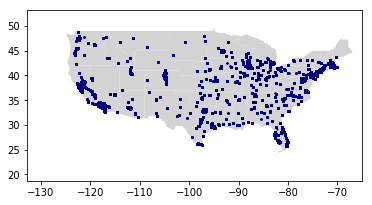

In [120]:
gs = GeoSeries(places.geometry)
base = states_gdf.plot(color='lightgrey')

bounds = gs.geometry.bounds
bounds
plt.xlim([bounds.minx.min()+25, bounds.maxx.max()+5])
plt.ylim([bounds.miny.min()-1, bounds.maxy.max()-8]);

gs.plot(ax=base,  color='navy', markersize=1)



## Evaluate the randomness of the test group assignment <a name="P32"></a>
Here, I do chi2 tests and t-tests of several characteristcs of users and their A/B assignment. I expect all of these to be not associated (e.g., I don't expect to reject the null hypothesis), because A/B assignment should have been randomly associated. 
_I am assuming this is a typical thing to do for A/B tests._

In [121]:
cat_var=['weekday', 'hour', 'operative_system', 'device', 'source']
for c in cat_var:
    crosstab_test = pd.crosstab(merge_data.test, merge_data[c],margins=False)
    print("chi2 p-value,", c, ":", stats.chi2_contingency(crosstab_test)[1])
    print(pd.crosstab(merge_data[c], merge_data.test, normalize='columns'))

chi2 p-value, weekday : 0.013508238914419659
test            0         1
weekday                    
0.0      0.060247  0.061465
1.0      0.062674  0.060569
2.0      0.059095  0.060200
3.0      0.117671  0.116051
4.0      0.291269  0.290184
5.0      0.234794  0.233718
6.0      0.174250  0.177814
chi2 p-value, hour : 1.145234861422912e-06
test         0         1
hour                    
0.0   0.018219  0.017745
1.0   0.018234  0.017665
2.0   0.018486  0.018430
3.0   0.017848  0.018772
4.0   0.017858  0.015794
5.0   0.017774  0.018790
6.0   0.016993  0.018280
7.0   0.034767  0.034672
8.0   0.052175  0.052504
9.0   0.070389  0.069151
10.0  0.088865  0.087387
11.0  0.103881  0.106107
12.0  0.120760  0.122648
13.0  0.054988  0.052311
14.0  0.051898  0.052592
15.0  0.051528  0.051687
16.0  0.053421  0.052935
17.0  0.051760  0.051687
18.0  0.052670  0.050818
19.0  0.017344  0.017920
20.0  0.017655  0.017261
21.0  0.017349  0.018535
22.0  0.017907  0.018395
23.0  0.017230  0.017911
chi2 p-val

This makes me concerned that the randomization did not work exactly--for example, 59.4% of control purchases were made on mobile but 57.8% of test purchases were made on mobile, althought qualitatively the differences are close.
__Ideally, the company would have done an A/A test before beginning. I am continuing assuming they did A/A testing and that the randomization worked correctly.__ 

## Compare conversion and revenue by control and test group <a name="P4"></a>

### Conversion <a name="P41"></a>

In [122]:
#compare conversion by the test and control group
merge_data.groupby('test')['converted'].describe()
#The conversion rate for the control group is greater than that for the test group. 

,count,mean,std,min,25%,50%,75%,max
test,,,,,,,,
0,202727.0,0.019904,0.139669,0.0,0.0,0.0,0.0,1.0
1,114073.0,0.015543,0.123698,0.0,0.0,0.0,0.0,1.0


In [123]:
### Use a chi2 test to evalaute the statistical significance of the difference
crosstab_test_conv = pd.crosstab(merge_data.test, merge_data.converted,margins=False)
crosstab_test_conv #a table of wether or not someone converted by control/test group

converted,0,1
test,,
0,198692,4035
1,112300,1773


In [124]:
print("chi2 p-value", stats.chi2_contingency(crosstab_test_conv)[1])
#The difference in conversion rate for the control group vs test group appears to be statistically significant 

chi2 p-value 1.8029808465845306e-18


### Revenue <a name="P42"></a>

In [125]:
merge_data['revenue']= merge_data['price_corrected']*merge_data['converted']
print("the average revenue per customer is", merge_data.revenue.mean())

the average revenue per customer is 0.8269318181818182


In [126]:
merge_data.groupby('test')['revenue'].describe()
#the revenue per customer is larger in the test group

,count,mean,std,min,25%,50%,75%,max
test,,,,,,,,
0,202727.0,0.776241,5.447109,0.0,0.0,0.0,0.0,39.0
1,114073.0,0.917018,7.298192,0.0,0.0,0.0,0.0,59.0


In [127]:
#I am using a Mann Whitney U test because the distributions in revenus are very not normally distributed
revenue_train = merge_data.loc[merge_data['test'] == 0]['revenue']
revenue_test = merge_data.loc[merge_data['test'] == 1]['revenue']
print("two-sample wilcoxon-test", mannwhitneyu(revenue_train, revenue_test, alternative='two-sided')[1])
#the difference in revenue by control vs test group appears to be statistically significant 

two-sample wilcoxon-test 3.3660746596158237e-16


# Actionable variables associated with conversion rate <a name="P5"></a>

In [139]:
def p_and_graph_cat(var):
    print(var)
    graph_by_convertive = (merge_data_state.groupby(['converted_x'])[var]
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .mul(100)
                         .reset_index())
    p = sns.barplot(x=var, y="percentage", hue="converted_x", data=graph_by_convertive, palette="Set2")
    print(graph_by_convertive)
    print("chi2 p-value:", stats.chi2_contingency(pd.crosstab(merge_data_state.converted_x, merge_data_state[var], margins=False))[1])


operative_system_cat
   converted_x operative_system_cat  percentage
0            0              windows   31.918506
1            0                  iOS   30.011704
2            0              android   23.735659
3            0                  mac    7.872550
4            0              missing    6.461581
5            1                  iOS   36.690771
6            1              windows   29.476584
7            1              android   19.266529
8            1                  mac   10.365014
9            1              missing    4.201102
chi2 p-value: 2.540473789009871e-49


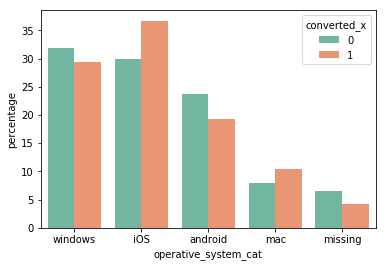

In [140]:
p_and_graph_cat('operative_system_cat')
#operative_system_cat is statistically significantly associated with conversion 

NAME
    converted_x                  NAME  percentage
0             0            California   18.887046
1             0              New York   11.286907
2             0                 Texas   10.789265
3             0               Florida    6.686686
4             0              Illinois    4.469145
5             0         Massachusetts    2.886246
6             0               Arizona    2.875878
7             0              Michigan    2.641498
8             0        North Carolina    2.615579
9             0              Virginia    2.481912
10            0            New Jersey    2.391937
11            0               Indiana    2.210135
12            0            Washington    2.191992
13            0                  Ohio    1.950206
14            0                Nevada    1.929841
15            0          Pennsylvania    1.763220
16            0             Tennessee    1.728785
17            0              Colorado    1.488481
18            0             Minnesota    1.47

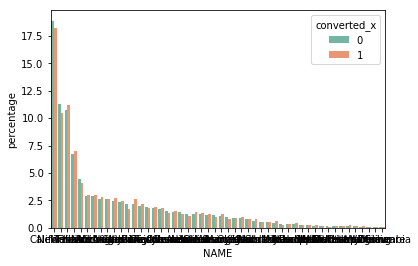

In [141]:
p_and_graph_cat('NAME')
#state name is statistically significantly associated with conversion 

source
    converted_x           source  percentage
0             0   direct_traffic   19.172077
1             0       ads-google   18.682507
2             0     ads_facebook   16.803409
3             0        ads_other    9.469520
4             0       seo-google    7.327774
5             0         ads-bing    7.266939
6             0     seo_facebook    6.709454
7             0  friend_referral    6.396271
8             0        seo-other    2.930659
9             0        ads-yahoo    2.401499
10            0        seo-yahoo    2.164600
11            0         seo-bing    0.675291
12            1       ads-google   21.973480
13            1     ads_facebook   19.493714
14            1  friend_referral   13.776477
15            1   direct_traffic   12.794903
16            1        ads_other    7.387636
17            1       seo-google    6.784915
18            1     seo_facebook    5.855003
19            1         ads-bing    4.718443
20            1        seo-other    2.496986
21 

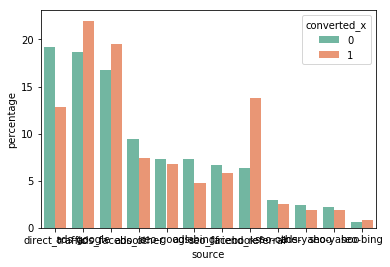

In [142]:
p_and_graph_cat('source')
#source is statistically significantly associated with conversion 

device
   converted_x  device  percentage
0            0  mobile   58.847494
1            0     web   41.152506
2            1  mobile   59.573003
3            1     web   40.426997
chi2 p-value: 0.27141766839639136


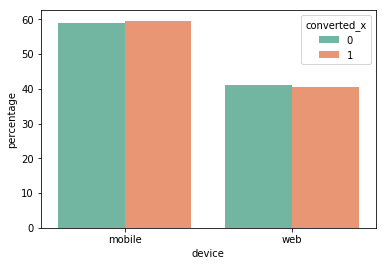

In [143]:
p_and_graph_cat('device')
#device is not statistically significantly associated with conversion 

weekday
    converted_x  weekday  percentage
0             0      4.0   29.081993
1             0      5.0   23.444936
2             0      6.0   17.542701
3             0      3.0   11.706841
4             0      1.0    6.202535
5             0      0.0    6.070751
6             0      2.0    5.950244
7             1      4.0   29.401621
8             1      5.0   23.210898
9             1      6.0   18.123814
10            1      3.0   11.812381
11            1      0.0    5.949302
12            1      2.0    5.897569
13            1      1.0    5.604415
chi2 p-value: 0.5519994976686295


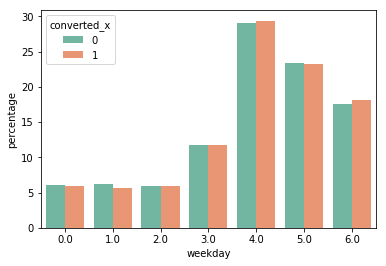

In [144]:
p_and_graph_cat('weekday')
#weekday is not statistically significantly associated with conversion 

hour
    converted_x  hour  percentage
0             0  12.0   12.146335
1             0  11.0   10.482122
2             0  10.0    8.834020
3             0   9.0    6.999681
4             0  13.0    5.406032
5             0  16.0    5.319036
6             0   8.0    5.213995
7             0  14.0    5.207551
8             0  18.0    5.198852
9             0  17.0    5.172430
10            0  15.0    5.156964
11            0   7.0    3.472453
12            0   2.0    1.842717
13            0   3.0    1.824673
14            0   5.0    1.822095
15            0  22.0    1.810496
16            0   0.0    1.807274
17            0   1.0    1.803407
18            0  21.0    1.779886
19            0  19.0    1.752820
20            0  20.0    1.752176
21            0   6.0    1.747343
22            0  23.0    1.747020
23            0   4.0    1.700622
24            1  12.0   12.019314
25            1  11.0    9.725815
26            1  10.0    8.794620
27            1   9.0    6.708053
28       

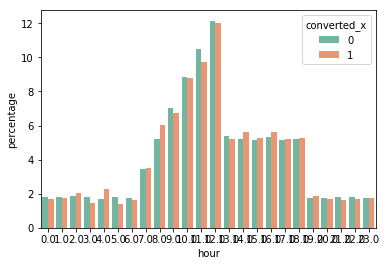

In [145]:
p_and_graph_cat('hour')
#hour is statistically significantly associated with conversion 

# Power calculation <a name="P6"></a>
## I am using a t-test power calculation. _I am assuming that the t test power calculation is approximating that for Mann Whitney U_. 


In [56]:
group_a = power.tt_ind_solve_power(effect_size=.07, alpha=0.05, power=0.8, ratio=.5, alternative='two-sided')
print("group A pop", group_a)
print("group B pop", 0.5 * group_a)


group A pop 4806.705693550453
group B pop 2403.3528467752267


In [111]:
#each group needs 1515 people per group.
print(merge_data['date'].value_counts().describe())
#the minimum visits per day ever was 1325
print((4806+2403)/(1325), "days")

count      91.000000
mean     3474.241758
std      2115.244385
min      1325.000000
25%      1489.500000
50%      2851.000000
75%      5627.000000
max      7235.000000
Name: date, dtype: float64
5.440754716981132 days


# Conclusions <a name="P7"></a>

I would reccomend to the company to run an A/A test before an A/B test next time to ensure that the assignment was truely random. The rest of my reccomendations are based on the assumption the assignment was truly random.

The data was very messy, and the company may want to explore making the data entry more automated and less prone to mistakes. 

If the company wants to maximize revenue, the company sell the software for 59 dollars. That price results in significant fewer sales, but significantly greater revenue. But if the company wants to maximize sales, it should sell the software for 39 dollars. This decision should be made in conjunction with the business team. 

Operating system, state, and source were statistically significantly associated with conversion rate. For example, customers using the operating system Mac, from the state Utah, or from the source Google Ads, all were more likely to convert than other groups-- these might be customers to specifically target in the future. The company may want to explore creating a machine learning model to target specific prices to specific users based on location, operating system, and source. 

Next time, to an effect of half the size observed here, the test could have been run for about 6 days. In the future, the company may want to consider running a power calcualtion before starting the experiment.

